In [33]:
import random
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display

## Load dataset

In [36]:
import os
import pandas as pd
from tqdm import tqdm

In [37]:
DATASET_PATH = '../data/3_final_data/'
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'

In [38]:
dataset = pd.read_csv(os.path.join(DATASET_PATH, 'logp_wo_averaging.csv'))

In [40]:
mols = dataset[SMILES_COLUMN].values

### Pharmacophores

#### Chemical Features

In [43]:
import os
from rdkit import RDConfig
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures

In [44]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [116]:
print(featFactory.GetFeatureFamilies())

('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


##### Fragmentation on Hydrophobe and Hydrophilic parts

Keep pharmacophore families of Hydrophobes

In [60]:
selectfeatFamily = 'Hydrophobe'
frags = {}
for idx, m in enumerate(sample_mols):
    selectFeats = []
    feats = featFactory.GetFeaturesForMol(m)
    print (idx, Chem.MolToSmiles(m, isomericSmiles=True), m.GetNumAtoms())
    sys.stdout.flush()
    for feat in feats:
        if feat.GetFamily().count(selectfeatFamily) == 0:
            print ("\t", feat.GetFamily(), feat.GetType(), feat.GetAtomIds())
            continue
        print ("\t", feat.GetFamily(), feat.GetType(), feat.GetAtomIds())
        sys.stdout.flush()
        selectFeats.append(feat)
    # end for
    paths = {}
    for feat in selectFeats:
        atomsIds = feat.GetAtomIds()
        if not selectfeatFamily in paths:
            paths[selectfeatFamily] = set(atomsIds)
        else:
            paths[selectfeatFamily] |= set(atomsIds)
        # end if
    # end for
    print()
    molfrags = []
    for featFamily, path in paths.items():
        path = sorted(list(path))
        print ("\t", featFamily, path)
        sys.stdout.flush()
        bs = []
        for atomId in range(m.GetNumAtoms()):
           if not atomId in path:
                atomSymbol = m.GetAtomWithIdx(atomId).GetSymbol()
                atomHs = m.GetAtomWithIdx(atomId).GetNumImplicitHs()
                print ("\t Checking Atom >>> ", atomId, atomSymbol, atomHs, " <<<")
                sys.stdout.flush()
                for x in path:
                    b = m.GetBondBetweenAtoms(atomId, x)
                    if b:
                        print ("\t Checking Bond >>> ", b.GetBondType(), atomId, x, " <<<")
                        sys.stdout.flush()
                        # Do not disconnect rings
                        if m.GetAtomWithIdx(atomId).IsInRing():
                            print ("\t In Ring >>> ", atomId, atomSymbol, b.GetBondType(), x, " <<<")
                            sys.stdout.flush()
                            #
                            path.append(atomId)
                            path = sorted(path)
                            print ("\t Updated path >>> ", featFamily, path, " <<<")
                            sys.stdout.flush()
                        # Do not disconnect terminal Carbons
                        elif (atomSymbol == "C") and (atomHs == 3):
                            print ("\t >>> ", atomId, atomSymbol, atomHs, b.GetBondType(), x, " <<<")
                            sys.stdout.flush()
                            #
                            path.append(atomId)
                            path = sorted(path)
                            print ("\t Updated path >>> ", featFamily, path, " <<<")
                            sys.stdout.flush()
                        else:
                            print ("\t >>> ", b.GetBondType(), atomId, x, " <<<")
                            sys.stdout.flush()
                            bs.append(b.GetIdx())
                        # end if
                    # end if
                # end for
            # end if
        # end for
        print ("\t >>> ", bs, " <<<")
        sys.stdout.flush()
        molfrags = []
        try:
            if len(bs):
                labels = [(i + 1, i + 1) for i, x in enumerate(bs)]
                nm = Chem.FragmentOnBonds(m, bs, dummyLabels=labels)
                print ("\t", idx, Chem.MolToSmiles(nm, isomericSmiles=True))
                sys.stdout.flush()
                molfrags += list(Chem.GetMolFrags(nm, asMols=True))
        except RuntimeError:
            print('runtime error')
        # end if
    # end for
    frags[idx] = molfrags
    # When a compound can not be fragmented into hydrophobic and hydrophilic
    # then add the compound as hydrophilic fragment
#     if frags[idx] == []:
#         frags[idx] = [m]
# end for

0 CCOC(=O)NN1CC=CCC1 12
	 Donor SingleAtomDonor (5,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (4,)

1 CCc1c(C)nc2n(c1=O)C(C)CCC2 15
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (9,)
	 Aromatic Arom6 (2, 3, 5, 6, 7, 8)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ChainTwoWayAttach (1,)

2 N=c1[nH]o[nH]c1=NC(=O)c1ccccc1 15
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (2,)
	 Donor SingleAtomDonor (4,)
	 Acceptor SingleAtomAcceptor (8,)
	 Aromatic Arom5 (1, 2, 3, 4, 5)
	 Aromatic Arom6 (9, 10, 11, 12, 13, 14)
	 Hydrophobe ThreeWayAttach (9,)
	 LumpedHydrophobe RH6_6 (9, 10, 11, 12, 13, 14)

3 O=C(O)CCCCC(=O)O 10
	 Donor SingleAtomDonor (2,)
	 Donor SingleAtomDonor (9,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor SingleAtomAcceptor (9,)
	 NegIonizable AcidicGroup (1, 0, 2)
	 NegIonizable AcidicGroup (7, 8, 9)
	 ZnBinder ZnBinder5 (3, 1, 0, 2)
	 ZnBinder ZnBinder5 (6, 

	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (5,)

21 COC1OC(CO)C(O)C(NC(=O)N(C)N=O)C1O 19
	 Donor SingleAtomDonor (6,)
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (18,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (18,)

22 CN(c1nc2ccccc2s1)C1CCN(CC(O)COc2ccc(F)cc2)CC1 29
	 Donor SingleAtomDonor (14,)
	 Donor SingleAtomDonor (17,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (17,)
	 Acceptor SingleAtomAcceptor (19,)
	 Acceptor SingleAtomAcceptor (24,)
	 PosIonizable BasicGroup (14,)
	 Aromatic Arom5 (2, 3, 4, 9, 10)
	 Aromatic Arom6 (4, 5, 6, 7, 8, 9)
	 Aromatic Arom6 (20, 21, 22, 23, 25, 26)
	 Hydrophobe ThreeWayAttach (9,)
	 LumpedHydrophobe RH6_6 (4, 5, 6, 7, 8, 9)
	 LumpedHydrophobe RH6_6 (20, 21, 22, 23, 25, 26)

23

	 Donor SingleAtomDonor (25,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (23,)
	 Acceptor SingleAtomAcceptor (33,)
	 Aromatic Arom6 (10, 11, 12, 13, 14, 15)
	 Aromatic Arom6 (30, 31, 32, 33, 34, 35)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (13,)
	 Hydrophobe ThreeWayAttach (15,)
	 Hydrophobe ThreeWayAttach (26,)
	 Hydrophobe ThreeWayAttach (29,)
	 Hydrophobe ThreeWayAttach (30,)
	 Hydrophobe ChainTwoWayAttach (8,)
	 LumpedHydrophobe iPropyl (1, 0, 2)

43 Clc1cc(Cl)c(Cl)c(Cl)c1Cl 11
	 Aromatic Arom6 (1, 2, 3, 5, 7, 9)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (9,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 5, 7, 9)

44 COCCOCCOCCOc1ccccc1OCCOCCOCCOC 28
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor S

	 Donor SingleAtomDonor (10,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor SingleAtomAcceptor (12,)
	 Aromatic Arom6 (2, 3, 4, 5, 6, 23)
	 Aromatic Arom6 (13, 14, 15, 16, 17, 18)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (13,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 5, 6, 23)
	 LumpedHydrophobe RH6_6 (13, 14, 15, 16, 17, 18)
	 LumpedHydrophobe tButyl (19, 20, 21, 22)

65 CCC(CC)=C(c1ccc(O)cc1)c1ccc(O)cc1 20
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (17,)
	 Acceptor SingleAtomAcceptor (10,)
	 Acceptor SingleAtomAcceptor (17,)
	 Aromatic Arom6 (6, 7, 8, 9, 11, 12)
	 Aromatic Arom6 (13, 14, 15, 16, 18, 19)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (13,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 11, 12)
	 LumpedHydrophobe RH6_6 (13, 14, 15, 16, 18, 19)

66 CC(C)(C)CC1=NS(=O)(=O)

	 Donor SingleAtomDonor (13,)
	 Donor SingleAtomDonor (15,)
	 Donor SingleAtomDonor (16,)
	 Donor SingleAtomDonor (18,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (21,)
	 Aromatic Arom6 (4, 5, 8, 9, 19, 20)
	 Aromatic Arom6 (11, 12, 13, 14, 16, 17)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ChainTwoWayAttach (10,)
	 LumpedHydrophobe RH6_6 (4, 5, 8, 9, 19, 20)

83 c1ccc2c(c1)Cc1cc3ccccc3cc1-2 17
	 Aromatic Arom6 (0, 1, 2, 3, 4, 5)
	 Aromatic Arom6 (7, 8, 9, 14, 15, 16)
	 Aromatic Arom6 (9, 10, 11, 12, 13, 14)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ThreeWayAttach (16,)
	 LumpedHydrophobe RH6_6 (0, 1, 2, 3, 4, 5)
	 LumpedHydrophobe RH6_6 (7, 8, 9, 14, 15, 16)
	 LumpedHydrophobe RH6_6 (9, 10, 

	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (10,)
	 LumpedHydrophobe RH6_6 (5, 6, 7, 8, 9, 10)

107 O=C(O)COc1cccc(F)c1 12
	 Donor SingleAtomDonor (2,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (10,)
	 NegIonizable AcidicGroup (1, 0, 2)
	 ZnBinder ZnBinder5 (3, 1, 0, 2)
	 Aromatic Arom6 (5, 6, 7, 8, 9, 11)
	 LumpedHydrophobe RH6_6 (5, 6, 7, 8, 9, 11)

108 O=C1c2cc([N+](=O)[O-])cc([N+](=O)[O-])c2-c2c1cc([N+](=O)[O-])cc2[N+](=O)[O-] 26
	 Acceptor SingleAtomAcceptor (0,)
	 Aromatic Arom6 (2, 3, 4, 8, 9, 13)
	 Aromatic Arom6 (14, 15, 16, 17, 21, 22)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ThreeWayAttach (13,)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ThreeWayAttach (15,)
	 LumpedHydrophobe Nitro2 (5, 6, 7)
	 LumpedHydrophobe Nitro2 (10, 11, 12)
	 LumpedHydrophobe Nitro2 (18, 19, 20)
	 LumpedHydrophobe Nitro2 (23, 24, 25)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 8, 9, 13)
	 Lum

130 CNCC(CC(C)C)c1ccccc1 14
	 Donor SingleAtomDonor (1,)
	 PosIonizable BasicGroup (1,)
	 Aromatic Arom6 (8, 9, 10, 11, 12, 13)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (8,)
	 Hydrophobe ChainTwoWayAttach (4,)
	 LumpedHydrophobe RH6_6 (8, 9, 10, 11, 12, 13)
	 LumpedHydrophobe iPropyl (5, 6, 7)

131 CCCc1nonc1C 9
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (6,)
	 Aromatic Arom5 (3, 4, 5, 6, 7)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)

132 COc1ccc([C@H]2C[C@H](C(F)(F)F)n3ncc(C(=O)N(C)Cc4cnn(C)c4C)c3N2)cc1OC 35
	 Donor SingleAtomDonor (19,)
	 Donor SingleAtomDonor (30,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (14,)
	 Acceptor SingleAtomAcceptor (18,)
	 Acceptor SingleAtomAcceptor (24,)
	 Acceptor SingleAtomAcceptor (33,)
	 Aromatic Arom5 (13, 14, 15, 16, 29)
	 Aromatic Arom5 (22, 23, 24, 25, 27)
	 Aromatic Arom6 (2, 3, 4, 5, 31, 32)
	 Hydrophobe ThreeWayAttach 

	 Donor SingleAtomDonor (1,)
	 PosIonizable BasicGroup (1,)
	 Aromatic Arom6 (7, 8, 9, 10, 11, 12)
	 Aromatic Arom6 (14, 15, 16, 17, 19, 20)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (12,)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ThreeWayAttach (17,)
	 Hydrophobe ThreeWayAttach (20,)
	 Hydrophobe ChainTwoWayAttach (4,)
	 Hydrophobe ChainTwoWayAttach (5,)
	 LumpedHydrophobe RH6_6 (6, 7, 12, 13, 14, 20)
	 LumpedHydrophobe RH6_6 (7, 8, 9, 10, 11, 12)
	 LumpedHydrophobe RH6_6 (14, 15, 16, 17, 19, 20)

155 COC(=O)c1cc(S(N)(=O)=O)ccc1S(=O)(=O)CCO 20
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (19,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (9,)
	 Acceptor SingleAtomAcceptor (10,)
	 Acceptor SingleAtomAcceptor (15,)
	 Acceptor SingleAtomAcceptor (16,)
	 Acceptor SingleAtomAcceptor (19,)
	 Aromatic Arom6 (4, 5, 6, 11, 12, 13)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe

	 Donor SingleAtomDonor (5,)
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (12,)
	 Donor SingleAtomDonor (20,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (19,)
	 Acceptor SingleAtomAcceptor (20,)
	 NegIonizable AcidicGroup (18, 19, 20)
	 PosIonizable BasicGroup (5,)
	 ZnBinder ZnBinder5 (13, 18, 19, 20)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (15,)
	 Hydrophobe ThreeWayAttach (21,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 Hydrophobe ChainTwoWayAttach (14,)
	 LumpedHydrophobe iPropyl (1, 0, 2)
	 LumpedHydrophobe iPropyl (15, 16, 17)
	 LumpedHydrophobe iPropyl (21, 22, 23)

178 CC(CSC(=O)c1ccccc1)C(=O)N1CC(Sc2ccccc2)CC1C(=O)O 29
	 Donor SingleAtomDonor (14,)
	 Donor SingleAtomDonor (28,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (13,)
	 Acceptor SingleAtomAcceptor (27,)
	 Acceptor SingleAtomAcceptor (28,)
	 NegIonizable AcidicGroup (26, 27, 28)
	 ZnBinder ZnBinder5 (25, 26, 27, 28)
	

198 C=c1[nH]cc(CO)c(=CNNC(=O)c2ccc([N+](=O)[O-])cc2)c1=O 24
	 Donor SingleAtomDonor (2,)
	 Donor SingleAtomDonor (6,)
	 Donor SingleAtomDonor (9,)
	 Donor SingleAtomDonor (10,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (23,)
	 Aromatic Arom6 (1, 2, 3, 4, 7, 22)
	 Aromatic Arom6 (13, 14, 15, 16, 20, 21)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (13,)
	 LumpedHydrophobe Nitro2 (17, 18, 19)
	 LumpedHydrophobe RH6_6 (13, 14, 15, 16, 20, 21)

199 COc1ccc(-c2cc(=S)ss2)cc1 14
	 Acceptor SingleAtomAcceptor (1,)
	 Aromatic Arom5 (6, 7, 8, 10, 11)
	 Aromatic Arom6 (2, 3, 4, 5, 12, 13)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (8,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 5, 12, 13)
	 LumpedHydrophobe RH5_5 (6, 7, 8, 10, 11)

200 CC(C)(C)c1ccc(O)c(C(C)(C)C)c1 15
	 Donor SingleAtomDonor (8,)
	 Acceptor SingleAtomAcceptor (8,)
	 Aromatic Arom6 

	 Donor SingleAtomDonor (5,)
	 Acceptor SingleAtomAcceptor (4,)
	 Aromatic Arom6 (6, 7, 8, 9, 11, 13)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 11, 13)

221 Clc1cc(Cl)c(-c2cc(Cl)c(Cl)cc2Cl)cc1Cl 18
	 Aromatic Arom6 (1, 2, 3, 5, 15, 16)
	 Aromatic Arom6 (6, 7, 8, 10, 12, 13)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (8,)
	 Hydrophobe ThreeWayAttach (10,)
	 Hydrophobe ThreeWayAttach (13,)
	 Hydrophobe ThreeWayAttach (16,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 5, 15, 16)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 10, 12, 13)

222 Cn1cnc([N+](=O)[O-])c1S(N)(=O)=O 13
	 Donor SingleAtomDonor (10,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (12,)
	 PosIonizable Imidazole (4, 3, 2, 1, 8)
	 Aromatic 

	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (3,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (10,)
	 Aromatic Arom6 (4, 5, 6, 7, 8, 9)
	 LumpedHydrophobe RH6_6 (4, 5, 6, 7, 8, 9)

242 CCc1cccc(NC(=O)NC)c1 13
	 Donor SingleAtomDonor (7,)
	 Donor SingleAtomDonor (10,)
	 Acceptor SingleAtomAcceptor (9,)
	 Aromatic Arom6 (2, 3, 4, 5, 6, 12)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 5, 6, 12)

243 COc1n[n+]([O-])c2ccccc2[n+]1[O-] 14
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 PosIonizable PosN (4,)
	 PosIonizable PosN (12,)
	 Aromatic Arom6 (2, 3, 4, 6, 11, 12)
	 Aromatic Arom6 (6, 7, 8, 9, 10, 11)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 10, 11)

244 CCCC(=O)OCC1OC(n2cc(F)c(=O)[nH]c2=O)CC1OC(=O)CCC 27
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (16,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor 

265 Nc1cccc(OC(=O)CNC(=O)c2ccccc2)c1 20
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (10,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor SingleAtomAcceptor (12,)
	 Aromatic Arom6 (1, 2, 3, 4, 5, 19)
	 Aromatic Arom6 (13, 14, 15, 16, 17, 18)
	 Hydrophobe ThreeWayAttach (13,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 5, 19)
	 LumpedHydrophobe RH6_6 (13, 14, 15, 16, 17, 18)

266 CC(=O)/N=c1/sc2nc3ccccc3nc2n1N(C(C)=O)C(C)=O 24
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (14,)
	 Acceptor SingleAtomAcceptor (20,)
	 Acceptor SingleAtomAcceptor (23,)
	 Aromatic Arom5 (4, 5, 6, 15, 16)
	 Aromatic Arom6 (6, 7, 8, 13, 14, 15)
	 Aromatic Arom6 (8, 9, 10, 11, 12, 13)
	 LumpedHydrophobe RH6_6 (8, 9, 10, 11, 12, 13)

267 COC(=O)C(C)N(C(=O)c1ccccc1)c1ccc(F)c(Cl)c1 23
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (8,)
	 Acceptor SingleAtomAcceptor (19,)
	 

	 Donor SingleAtomDonor (9,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (9,)
	 Aromatic Arom6 (3, 4, 5, 6, 8, 10)
	 LumpedHydrophobe iPropyl (1, 0, 2)

290 O=C(/C=C/c1ccccc1)Nc1cccc(NC(=O)c2cccc(Cl)c2)c1 27
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (16,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor SingleAtomAcceptor (18,)
	 Aromatic Arom6 (4, 5, 6, 7, 8, 9)
	 Aromatic Arom6 (11, 12, 13, 14, 15, 26)
	 Aromatic Arom6 (19, 20, 21, 22, 23, 25)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (19,)
	 Hydrophobe ThreeWayAttach (23,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 LumpedHydrophobe RH6_6 (4, 5, 6, 7, 8, 9)
	 LumpedHydrophobe RH6_6 (11, 12, 13, 14, 15, 26)
	 LumpedHydrophobe RH6_6 (19, 20, 21, 22, 23, 25)

291 NC(=O)CCCc1ccccc1 12
	 Donor SingleAtomDonor (0,)
	 Acceptor SingleAtomAcceptor (2,)
	 Aromatic Arom6 (6, 7, 8, 9, 10, 11)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 Hydr

	 LumpedHydrophobe Nitro2 (9, 10, 11)

314 O=c1cc(C(O)O)oc2ccc(Cl)cc12 15
	 Donor SingleAtomDonor (5,)
	 Donor SingleAtomDonor (6,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (6,)
	 Aromatic Arom6 (1, 2, 3, 7, 8, 14)
	 Aromatic Arom6 (8, 9, 10, 11, 13, 14)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ThreeWayAttach (14,)
	 LumpedHydrophobe RH6_6 (8, 9, 10, 11, 13, 14)

315 CC(C)CC(N)C(=O)NC(CC(C)C)C(=O)N1CCCC1C(=O)NC(CC(C)C)C(=O)O 32
	 Donor SingleAtomDonor (5,)
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (16,)
	 Donor SingleAtomDonor (23,)
	 Donor SingleAtomDonor (31,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (15,)
	 Acceptor SingleAtomAcceptor (22,)
	 Acceptor SingleAtomAcceptor (30,)
	 Acceptor SingleAtomAcceptor (31,)
	 NegIonizable AcidicGroup (29, 30, 31)
	 PosIonizable BasicGroup (5,)
	 ZnBinder ZnBinder5 (24, 29, 30, 31)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (11,)


335 CCCCCCOCCO 10
	 Donor SingleAtomDonor (9,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (9,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 Hydrophobe ChainTwoWayAttach (4,)

336 Cc1ccccc1C#N 9
	 Aromatic Arom6 (1, 2, 3, 4, 5, 6)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (6,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 5, 6)

337 NC(=O)c1cnc2ccccc2n1 13
	 Donor SingleAtomDonor (0,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (12,)
	 Aromatic Arom6 (3, 4, 5, 6, 11, 12)
	 Aromatic Arom6 (6, 7, 8, 9, 10, 11)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 10, 11)

338 CCOC(=O)CC(CN)c1ccc(Cl)cc1 16
	 Donor SingleAtomDonor (8,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (4,)
	 PosIonizable BasicGroup (8,)
	 Aromatic Arom6 (9, 10, 11, 12, 14, 15)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe Th

	 Donor SingleAtomDonor (0,)
	 Acceptor SingleAtomAcceptor (0,)
	 Aromatic Arom6 (1, 2, 4, 5, 7, 8)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (8,)
	 LumpedHydrophobe RH6_6 (1, 2, 4, 5, 7, 8)

362 CCCc1ccc(OCC(C)O)c2c(=O)cc(C(=O)O)oc12 22
	 Donor SingleAtomDonor (11,)
	 Donor SingleAtomDonor (19,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (14,)
	 Acceptor SingleAtomAcceptor (18,)
	 Acceptor SingleAtomAcceptor (19,)
	 NegIonizable AcidicGroup (17, 18, 19)
	 ZnBinder ZnBinder5 (16, 17, 18, 19)
	 Aromatic Arom6 (3, 4, 5, 6, 12, 21)
	 Aromatic Arom6 (12, 13, 15, 16, 20, 21)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (12,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 LumpedHydrophobe RH6_6 (3, 4, 5, 6, 12, 21)

363 Oc1ccccc1O 8
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (7,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor Single

	 Donor SingleAtomDonor (0,)
	 Acceptor SingleAtomAcceptor (0,)
	 Aromatic Arom6 (1, 2, 3, 4, 5, 6)
	 Hydrophobe ThreeWayAttach (6,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 5, 6)

384 Clc1ccc(Oc2c(Cl)cccc2Cl)c(Cl)c1Cl 18
	 Acceptor SingleAtomAcceptor (5,)
	 Aromatic Arom6 (1, 2, 3, 4, 14, 16)
	 Aromatic Arom6 (6, 7, 9, 10, 11, 12)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (12,)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ThreeWayAttach (16,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 14, 16)
	 LumpedHydrophobe RH6_6 (6, 7, 9, 10, 11, 12)

385 CSc1ccc2ccccc2n1 12
	 Acceptor SingleAtomAcceptor (11,)
	 Aromatic Arom6 (2, 3, 4, 5, 10, 11)
	 Aromatic Arom6 (5, 6, 7, 8, 9, 10)
	 Hydrophobe ThreeWayAttach (5,)
	 LumpedHydrophobe RH6_6 (5, 6, 7, 8, 9, 10)

386 CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2(O)C(O)CO 25
	 Donor SingleAtomDonor (20,)
	 Donor SingleAtomDonor (22,)
	 Donor SingleAtomDonor (24,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor Single

	 Donor SingleAtomDonor (0,)
	 Acceptor SingleAtomAcceptor (5,)
	 Aromatic Arom6 (1, 2, 3, 4, 6, 7)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 6, 7)

406 Cn1c(=O)c(C(=O)CN2CCSc3ccccc32)c(N)n(Cc2ccccc2)c1=O 30
	 Donor SingleAtomDonor (19,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (29,)
	 Aromatic Arom6 (1, 2, 4, 18, 20, 28)
	 Aromatic Arom6 (12, 13, 14, 15, 16, 17)
	 Aromatic Arom6 (22, 23, 24, 25, 26, 27)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (12,)
	 Hydrophobe ThreeWayAttach (22,)
	 LumpedHydrophobe RH6_6 (12, 13, 14, 15, 16, 17)
	 LumpedHydrophobe RH6_6 (22, 23, 24, 25, 26, 27)

407 Cc1ccccc1C1=CCN(C)CC1 14
	 Donor SingleAtomDonor (10,)
	 PosIonizable BasicGroup (10,)
	 Aromatic Arom6 (1, 2, 3, 4, 5, 6)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (7,)
	 LumpedHydrophobe RH6_6 (1, 2, 3, 4, 5, 6)

408 CSC(C)=NO 6
	 Donor SingleAtomDonor (5,)
	 Acceptor SingleAt

	 Donor SingleAtomDonor (5,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (5,)
	 NegIonizable AcidicGroup (3, 4, 5)
	 ZnBinder ZnBinder5 (2, 3, 4, 5)
	 Aromatic Arom6 (6, 7, 8, 9, 10, 11)
	 Hydrophobe ThreeWayAttach (1,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 10, 11)

428 CCCCCCCCCCCCn1cc(C(O)OC)cc1O 22
	 Donor SingleAtomDonor (16,)
	 Donor SingleAtomDonor (21,)
	 Acceptor SingleAtomAcceptor (16,)
	 Acceptor SingleAtomAcceptor (17,)
	 Acceptor SingleAtomAcceptor (21,)
	 Aromatic Arom5 (12, 13, 14, 19, 20)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 Hydrophobe ChainTwoWayAttach (4,)
	 Hydrophobe ChainTwoWayAttach (5,)
	 Hydrophobe ChainTwoWayAttach (6,)
	 Hydrophobe ChainTwoWayAttach (7,)
	 Hydrophobe ChainTwoWayAttach (8,)
	 Hydrophobe ChainTwoWayAttach (9,)
	 Hydrophobe ChainTwoWayAttach (10,)

429 C

	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (9,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (13,)
	 Hydrophobe ChainTwoWayAttach (6,)
	 Hydrophobe ChainTwoWayAttach (7,)

449 O=C(c1ccco1)C(O)c1ccco1 14
	 Donor SingleAtomDonor (8,)
	 Acceptor SingleAtomAcceptor (0,)
	 Acceptor SingleAtomAcceptor (8,)
	 Aromatic Arom5 (2, 3, 4, 5, 6)
	 Aromatic Arom5 (9, 10, 11, 12, 13)

450 c1ccc(P(c2ccccc2)c2ccccc2)cc1 19
	 Aromatic Arom6 (0, 1, 2, 3, 17, 18)
	 Aromatic Arom6 (5, 6, 7, 8, 9, 10)
	 Aromatic Arom6 (11, 12, 13, 14, 15, 16)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (11,)
	 LumpedHydrophobe RH6_6 (0, 1, 2, 3, 17, 18)
	 LumpedHydrophobe RH6_6 (5, 6, 7, 8, 9, 10)
	 LumpedHydrophobe RH6_6 (11, 12, 13, 14, 15, 16)

451 O=[N+]([O-])c1cccc(F)c1 10
	 Acceptor SingleAtomAcceptor (8,)
	 Aromatic Arom6 (3, 4, 5, 6, 7, 9)
	 LumpedHydropho

471 Cc1cnc2ccccn2c1=O 12
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (11,)
	 Aromatic Arom6 (1, 2, 3, 4, 9, 10)
	 Aromatic Arom6 (4, 5, 6, 7, 8, 9)
	 Hydrophobe ThreeWayAttach (1,)

472 COc1cccc(OC)c1C(=O)Nc1ccc(N2CCN(C(=O)c3ccccc3C)CC2)cc1 34
	 Donor SingleAtomDonor (12,)
	 Donor SingleAtomDonor (20,)
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (22,)
	 Aromatic Arom6 (2, 3, 4, 5, 6, 9)
	 Aromatic Arom6 (13, 14, 15, 16, 32, 33)
	 Aromatic Arom6 (23, 24, 25, 26, 27, 28)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe ThreeWayAttach (23,)
	 Hydrophobe ThreeWayAttach (28,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 5, 6, 9)
	 LumpedHydrophobe RH6_6 (13, 14, 15, 16, 32, 33)
	 LumpedHydrophobe RH6_6 (23, 24, 25, 26, 27, 28)

473 O=C(CBr)NC(CO)C(O)c1ccc([N+](=O)[O-])cc1 19
	 Donor SingleAtomDonor (4,)
	 Donor SingleAtomDonor (7,)
	 Donor SingleAtomDonor (9,)
	 Acceptor SingleAtomAcceptor (0

493 Cc1cn(C2CC(O)C(CO)O2)c(=O)[nH]c1=O 17
	 Donor SingleAtomDonor (3,)
	 Donor SingleAtomDonor (7,)
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (14,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (10,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (13,)
	 Acceptor SingleAtomAcceptor (16,)
	 Aromatic Arom6 (1, 2, 3, 12, 14, 15)
	 Hydrophobe ThreeWayAttach (1,)

494 COc1cc(Cc2c[nH]c(=N)[nH]c2=N)ccc1C(C)C 20
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (11,)
	 Donor SingleAtomDonor (13,)
	 Acceptor SingleAtomAcceptor (1,)
	 Aromatic Arom6 (2, 3, 4, 14, 15, 16)
	 Aromatic Arom6 (6, 7, 8, 9, 11, 12)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ThreeWayAttach (16,)
	 Hydrophobe ThreeWayAttach (17,)
	 Hydrophobe ChainTwoWayAttach (5,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 14, 15, 16)
	 LumpedHydrophobe iPropyl (17, 18, 19)

495 COc1ccc(OCC(=O)NNC(C)C)cc1 17
	 Donor SingleAtomD

	 Donor SingleAtomDonor (14,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (17,)
	 Aromatic Arom6 (5, 6, 7, 8, 12, 13)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 LumpedHydrophobe Nitro2 (9, 10, 11)
	 LumpedHydrophobe RH6_6 (5, 6, 7, 8, 12, 13)

515 CCOc1ccccc1C(=O)N1CCCCC1 17
	 Donor SingleAtomDonor (11,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (10,)
	 Aromatic Arom6 (3, 4, 5, 6, 7, 8)
	 Hydrophobe ThreeWayAttach (8,)
	 LumpedHydrophobe RH6_6 (3, 4, 5, 6, 7, 8)

516 CN(C)C(N(C)C)=S(I)c1cccc(I)c1 16
	 Donor SingleAtomDonor (1,)
	 Donor SingleAtomDonor (4,)
	 Aromatic Arom6 (9, 10, 11, 12, 13, 15)
	 Hydrophobe ThreeWayAttach (9,)
	 Hydrophobe ThreeWayAttach (13,)
	 LumpedHydrophobe RH6_6 (9, 10, 11, 12, 13, 15)

517 Cc1cc2c(cc1S(N)(=O)=O)S(=O)(=O)NCN2 17
	 Donor SingleAtomDonor (8,)
	 Donor SingleAtomDonor (14,)
	 Donor SingleAtomDonor (16,)
	 Acceptor SingleAtomAcceptor (9,)
	 Acceptor SingleAtomAcceptor (10,)
	

539 CCC(CC)C(=O)NS(=O)(=O)c1ccc(C(F)(F)F)cc1N 22
	 Donor SingleAtomDonor (7,)
	 Donor SingleAtomDonor (21,)
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (9,)
	 Acceptor SingleAtomAcceptor (10,)
	 Aromatic Arom6 (11, 12, 13, 14, 19, 20)
	 Hydrophobe ThreeWayAttach (2,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ThreeWayAttach (14,)
	 Hydrophobe ChainTwoWayAttach (1,)
	 Hydrophobe ChainTwoWayAttach (3,)
	 LumpedHydrophobe RH6_6 (11, 12, 13, 14, 19, 20)

540 NS(=O)(=O)c1ccc2c(c1)S(=O)(=O)NCN2 16
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (13,)
	 Donor SingleAtomDonor (15,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (12,)
	 Aromatic Arom6 (4, 5, 6, 7, 8, 9)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (8,)
	 LumpedHydrophobe RH6_6 (4, 5, 6, 7, 8, 9)

541 C=CCS(=O)(=O)c1cc(OC)c(OC)c(OC)c1 18
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcc

	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (8,)
	 Aromatic Arom6 (12, 13, 14, 15, 17, 18)
	 Hydrophobe ThreeWayAttach (12,)
	 Hydrophobe ThreeWayAttach (15,)
	 Hydrophobe ThreeWayAttach (18,)
	 Hydrophobe ChainTwoWayAttach (10,)
	 LumpedHydrophobe RH6_6 (12, 13, 14, 15, 17, 18)

564 CC(=O)NC(Cc1ccccc1)C(=O)NC(CCC(N)=O)C(N)=O 24
	 Donor SingleAtomDonor (3,)
	 Donor SingleAtomDonor (14,)
	 Donor SingleAtomDonor (19,)
	 Donor SingleAtomDonor (22,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (13,)
	 Acceptor SingleAtomAcceptor (20,)
	 Acceptor SingleAtomAcceptor (23,)
	 Aromatic Arom6 (6, 7, 8, 9, 10, 11)
	 Hydrophobe ThreeWayAttach (6,)
	 Hydrophobe ChainTwoWayAttach (5,)
	 Hydrophobe ChainTwoWayAttach (16,)
	 Hydrophobe ChainTwoWayAttach (17,)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 10, 11)

565 CC1CCC(=O)N1C 8
	 Donor SingleAtomDonor (6,)
	 Acceptor SingleAtomAcceptor (5,)

566

586 CNC(=S)NCC#CCC(NC(=O)C(Cc1ccc2ccccc2c1)Cc1cccc2ccccc12)C(=O)NC(CC1CCCCC1)C(O)CC(=O)NCCN1CCOCC1 61
	 Donor SingleAtomDonor (1,)
	 Donor SingleAtomDonor (4,)
	 Donor SingleAtomDonor (10,)
	 Donor SingleAtomDonor (38,)
	 Donor SingleAtomDonor (48,)
	 Donor SingleAtomDonor (52,)
	 Donor SingleAtomDonor (55,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (37,)
	 Acceptor SingleAtomAcceptor (48,)
	 Acceptor SingleAtomAcceptor (51,)
	 Acceptor SingleAtomAcceptor (58,)
	 PosIonizable BasicGroup (55,)
	 Aromatic Arom6 (15, 16, 17, 18, 23, 24)
	 Aromatic Arom6 (18, 19, 20, 21, 22, 23)
	 Aromatic Arom6 (26, 27, 28, 29, 30, 35)
	 Aromatic Arom6 (30, 31, 32, 33, 34, 35)
	 Hydrophobe ThreeWayAttach (13,)
	 Hydrophobe ThreeWayAttach (15,)
	 Hydrophobe ThreeWayAttach (18,)
	 Hydrophobe ThreeWayAttach (23,)
	 Hydrophobe ThreeWayAttach (26,)
	 Hydrophobe ThreeWayAttach (30,)
	 Hydrophobe ThreeWayAttach (35,)
	 Hydrophobe ThreeWayAttach (41,)
	 Hydrophobe ChainTwoWayAttach (6,)
	 

605 Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)n(-c2ccc3o[nH]c(=N)c3c2)n1 35
	 Donor SingleAtomDonor (6,)
	 Donor SingleAtomDonor (18,)
	 Donor SingleAtomDonor (29,)
	 Donor SingleAtomDonor (31,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (19,)
	 Acceptor SingleAtomAcceptor (20,)
	 Acceptor SingleAtomAcceptor (34,)
	 Aromatic Arom5 (1, 2, 3, 23, 34)
	 Aromatic Arom5 (27, 28, 29, 30, 32)
	 Aromatic Arom6 (7, 8, 9, 10, 21, 22)
	 Aromatic Arom6 (11, 12, 13, 14, 15, 16)
	 Aromatic Arom6 (24, 25, 26, 27, 32, 33)
	 Hydrophobe ThreeWayAttach (10,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ThreeWayAttach (16,)
	 Hydrophobe ThreeWayAttach (32,)
	 LumpedHydrophobe RH6_6 (7, 8, 9, 10, 21, 22)
	 LumpedHydrophobe RH6_6 (11, 12, 13, 14, 15, 16)
	 LumpedHydrophobe RH6_6 (24, 25, 26, 27, 32, 33)

606 CSC(C)=NOC(=O)N(C)SN(C)C(=O)c1c(Cl)cccc1Cl 23
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (7,)
	 Acceptor SingleAtomAcceptor (14,)
	 Aromatic Arom6 (15, 16, 

627 CNc1ccc(-c2nc3ccc(C#N)cc3s2)cc1 19
	 Donor SingleAtomDonor (1,)
	 Acceptor SingleAtomAcceptor (7,)
	 Aromatic Arom5 (6, 7, 8, 15, 16)
	 Aromatic Arom6 (2, 3, 4, 5, 17, 18)
	 Aromatic Arom6 (8, 9, 10, 11, 14, 15)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ThreeWayAttach (15,)
	 LumpedHydrophobe RH6_6 (2, 3, 4, 5, 17, 18)
	 LumpedHydrophobe RH6_6 (8, 9, 10, 11, 14, 15)

628 NC(Cc1ccccc1)C(=O)OCn1ncc2c(=O)[nH]cnc21 23
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (19,)
	 Donor SingleAtomDonor (21,)
	 Acceptor SingleAtomAcceptor (10,)
	 Acceptor SingleAtomAcceptor (11,)
	 Acceptor SingleAtomAcceptor (14,)
	 Acceptor SingleAtomAcceptor (18,)
	 Acceptor SingleAtomAcceptor (21,)
	 PosIonizable BasicGroup (0,)
	 Aromatic Arom5 (13, 14, 15, 16, 22)
	 Aromatic Arom6 (3, 4, 5, 6, 7, 8)
	 Aromatic Arom6 (16, 17, 19, 20, 21, 22)
	 Hydrophobe ThreeWayAttach (3,)
	 Hydrophobe ThreeWayAttach (16,)
	 Hydrophobe ChainTwoWayAttach (2,)
	 LumpedHydrophobe RH

650 CCOC(=O)C(=Cc1cccc(C)c1)C(=O)OCC 19
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (4,)
	 Acceptor SingleAtomAcceptor (15,)
	 Acceptor SingleAtomAcceptor (16,)
	 Aromatic Arom6 (7, 8, 9, 10, 11, 13)
	 Hydrophobe ThreeWayAttach (5,)
	 Hydrophobe ThreeWayAttach (7,)
	 Hydrophobe ThreeWayAttach (11,)
	 Hydrophobe ChainTwoWayAttach (6,)
	 LumpedHydrophobe RH6_6 (7, 8, 9, 10, 11, 13)

651 NS(=O)(=O)c1nc2ccc(OCCO)cc2s1 17
	 Donor SingleAtomDonor (0,)
	 Donor SingleAtomDonor (13,)
	 Acceptor SingleAtomAcceptor (2,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (5,)
	 Acceptor SingleAtomAcceptor (10,)
	 Acceptor SingleAtomAcceptor (13,)
	 Aromatic Arom5 (4, 5, 6, 15, 16)
	 Aromatic Arom6 (6, 7, 8, 9, 14, 15)
	 Hydrophobe ThreeWayAttach (15,)
	 LumpedHydrophobe RH6_6 (6, 7, 8, 9, 14, 15)

652 CC(C)OC(=O)CSc1ccc([N+](=O)[O-])cc1Cl 18
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (5,)
	 Aromatic Arom6 (8, 9, 10, 11, 15, 16)
	 Hydrophobe 

669 COC(=O)C1=C(C)N=C(C)C(C(=O)OC)C1c1ccccc1[N+](=O)[O-] 25
	 Acceptor SingleAtomAcceptor (1,)
	 Acceptor SingleAtomAcceptor (3,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (13,)
	 Aromatic Arom6 (16, 17, 18, 19, 20, 21)
	 Hydrophobe ThreeWayAttach (4,)
	 Hydrophobe ThreeWayAttach (10,)
	 Hydrophobe ThreeWayAttach (15,)
	 Hydrophobe ThreeWayAttach (16,)
	 LumpedHydrophobe Nitro2 (22, 23, 24)
	 LumpedHydrophobe RH6_6 (16, 17, 18, 19, 20, 21)

670 c1ccc2c(c1)OCCOCCOCCOCCOCCOCCOc1ccccc1OCCO2 35
	 Acceptor SingleAtomAcceptor (6,)
	 Acceptor SingleAtomAcceptor (9,)
	 Acceptor SingleAtomAcceptor (12,)
	 Acceptor SingleAtomAcceptor (15,)
	 Acceptor SingleAtomAcceptor (18,)
	 Acceptor SingleAtomAcceptor (21,)
	 Acceptor SingleAtomAcceptor (24,)
	 Acceptor SingleAtomAcceptor (31,)
	 Acceptor SingleAtomAcceptor (34,)
	 Aromatic Arom6 (0, 1, 2, 3, 4, 5)
	 Aromatic Arom6 (25, 26, 27, 28, 29, 30)
	 LumpedHydrophobe RH6_6 (0, 1, 2, 3, 4, 5)
	 LumpedHydrophobe RH6_6 (25, 26, 27

## Get HBI index

In [118]:
from tqdm import tqdm
from rdkit.Chem import Descriptors
mols = dataset[SMILES_COLUMN].values
selectfeatFamily = 'Hydrophobe'
frags = []
phob_mass = []
for smiles in tqdm(mols):
    m = Chem.MolFromSmiles(smiles)
    selectFeats = []
    feats = featFactory.GetFeaturesForMol(m)
    for feat in feats:
        if feat.GetFamily().count(selectfeatFamily) == 0:
            continue
        selectFeats.append(feat)
    # end for
    paths = {}
    
    for feat in selectFeats:
        atomsIds = feat.GetAtomIds()
        if not selectfeatFamily in paths:
            paths[selectfeatFamily] = set(atomsIds)
        else:
            paths[selectfeatFamily] |= set(atomsIds)
        # end if
    # end for
    molfrags = []
    mass = 0
    for featFamily, path in paths.items():
        path = sorted(list(path))
        sys.stdout.flush()
        bs = []
        for atomId in range(m.GetNumAtoms()):
           if not atomId in path:
                atomSymbol = m.GetAtomWithIdx(atomId).GetSymbol()
                atomHs = m.GetAtomWithIdx(atomId).GetNumImplicitHs()
                for x in path:
                    b = m.GetBondBetweenAtoms(atomId, x)
                    if b:                       
                        # Do not disconnect rings
                        if m.GetAtomWithIdx(atomId).IsInRing():
                            path.append(atomId)
                            path = sorted(path)
                        # Do not disconnect terminal Carbons
                        elif (atomSymbol == "C") and (atomHs == 3):

                            path.append(atomId)
                            path = sorted(path)

                        else:
                            bs.append(b.GetIdx())
                        # end if
                    # end if
                # end for
            # end if
            
        # end for
        molfrags = []
        
        try:
            if len(bs):
                labels = [(i + 1, i + 1) for i, x in enumerate(bs)]
                nm = Chem.FragmentOnBonds(m, bs, dummyLabels=labels)
                molfrags += list(Chem.GetMolFrags(nm, asMols=True))
        except:
            pass
        # end if
    # end for
    frags.append(molfrags)
    mass = 0
    atoms = []
    for path in paths.values():
        for atomId in path:
            if atomId in atoms:
                pass
            mass+=m.GetAtomWithIdx(atomId).GetMass()
            atoms.append(atomId)
    phob_mass.append(mass)
# end for

  0%|          | 0/13777 [00:00<?, ?it/s]RDKit ERROR: Failed Expression: 3664034592 < 52
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:11] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 778776848 < 20
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:11] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 778933872 < 28
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:11] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: 

  3%|▎         | 448/13777 [00:02<01:28, 150.55it/s]RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 772770912 < 44
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3653350384 < 28
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3650773904 < 29
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:17] 
RDKit ERROR: 
RDKit ERROR: ****
R

  6%|▌         | 832/13777 [00:05<01:25, 151.16it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3655284944 < 19
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3655304992 < 37
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3656518912 < 37
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2


 10%|▉         | 1316/13777 [00:08<01:08, 183.04it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3644774560 < 31
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3656341344 < 18
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3649531056 < 44
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 12%|█▏        | 1637/13777 [00:10<01:18, 154.95it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3641004064 < 33
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3646253584 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3650092608 < 31
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 14%|█▍        | 1937/13777 [00:12<01:19, 149.21it/s]RDKit ERROR: Failed Expression: 3663152112 < 18
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3663208208 < 11
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 781020544 < 36
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp


 16%|█▋        | 2273/13777 [00:14<01:08, 168.40it/s]RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3667963216 < 21
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:29] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3667192080 < 36
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:29] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3644890480 < 21
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:29] 
RDKit ERROR: 
RDKit ERROR: ****

 19%|█▉        | 2645/13777 [00:16<01:08, 162.68it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3660339008 < 13
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:31] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3660235376 < 32
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:31] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3668957792 < 35
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:31] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 22%|██▏       | 3042/13777 [00:18<01:06, 160.49it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3672783648 < 54
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3674435808 < 54
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3670695104 < 22
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 25%|██▌       | 3467/13777 [00:21<01:05, 157.12it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3676204960 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:35] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3676682928 < 17
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:36] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3677914992 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:36] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 27%|██▋       | 3724/13777 [00:22<00:58, 173.30it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3681612128 < 31
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3681652544 < 19
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3680237968 < 30
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 30%|██▉       | 4120/13777 [00:25<00:51, 186.77it/s]RDKit ERROR: Failed Expression: 3682505536 < 19
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3658709200 < 18
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3682539424 < 39
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp

 33%|███▎      | 4570/13777 [00:27<00:52, 175.19it/s]RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3685588272 < 25
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:42] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3689242608 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:42] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3689307312 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:42] 
RDKit ERROR: 
RDKit ERROR: ****

 36%|███▋      | 5016/13777 [00:30<00:50, 173.58it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3683053936 < 31
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3692590464 < 20
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3691515728 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:45] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 39%|███▊      | 5327/13777 [00:32<00:47, 177.14it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3695948272 < 36
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:47] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3696018320 < 10
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:47] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3688481632 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:47] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 40%|████      | 5537/13777 [00:33<00:46, 175.97it/s]RDKit ERROR: [19:15:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3698655008 < 22
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3698661808 < 18
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3697969184 < 25
RDKit ERROR: ****
RDKit ERROR: 

 42%|████▏     | 5828/13777 [00:35<00:51, 155.66it/s]RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3703682704 < 24
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:50] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3700660640 < 17
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:50] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3702557952 < 27
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:50] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error

 45%|████▌     | 6201/13777 [00:37<00:46, 164.44it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3701780864 < 25
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3705876320 < 17
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3705019440 < 28
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 48%|████▊     | 6578/13777 [00:39<00:50, 141.51it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3708351360 < 25
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:54] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3708340736 < 25
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:54] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3709308192 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:55] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 50%|█████     | 6918/13777 [00:41<00:38, 177.54it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3711527072 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:56] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3711513872 < 35
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:56] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3713029136 < 22
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:56] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 53%|█████▎    | 7360/13777 [00:44<00:40, 159.22it/s]RDKit ERROR: Failed Expression: 3715184752 < 35
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:59] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3715270416 < 32
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:59] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3718371616 < 62
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:15:59] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp

 56%|█████▋    | 7751/13777 [00:46<00:33, 180.41it/s]RDKit ERROR: 
RDKit ERROR: [19:16:01] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3720545552 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:01] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3721685744 < 21
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:01] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3721664112 < 69
RDKit ERROR: ****

 59%|█████▉    | 8182/13777 [00:48<00:34, 160.36it/s]RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3724891472 < 25
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:04] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3724441888 < 27
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:04] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3723234256 < 30
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:04] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error

 62%|██████▏   | 8549/13777 [00:50<00:29, 174.96it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3728546784 < 42
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3729925152 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3729892400 < 19
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 65%|██████▌   | 8970/13777 [00:53<00:26, 183.95it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3733170384 < 63
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:08] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3731855440 < 36
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:08] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3732389760 < 24
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:08] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 68%|██████▊   | 9368/13777 [00:55<00:23, 188.58it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3736291552 < 35
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:10] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3735359056 < 32
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:10] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3737307424 < 31
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:10] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2

 71%|███████   | 9751/13777 [00:57<00:23, 173.15it/s]RDKit ERROR: Failed Expression: 3738821728 < 18
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:12] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3740372352 < 51
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:13] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3735672928 < 27
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:13] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp

 73%|███████▎  | 10124/13777 [00:59<00:19, 182.78it/s]RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:15] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3743586240 < 46
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:15] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3743776976 < 33
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:15] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3736018416 < 7

 76%|███████▌  | 10478/13777 [01:01<00:19, 172.86it/s]RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3746619344 < 30
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3736075792 < 39
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3746186928 < 23
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Erro

 79%|███████▉  | 10850/13777 [01:04<00:16, 179.70it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3751256816 < 45
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:19] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3746882096 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:19] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3750600432 < 37
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:19] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid

 82%|████████▏ | 11274/13777 [01:06<00:14, 177.00it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3748329360 < 22
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:21] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3753168896 < 20
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:21] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3752748304 < 32
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:21] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid

 84%|████████▍ | 11620/13777 [01:08<00:12, 166.22it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3757185840 < 26
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:23] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4162103808 < 45
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:23] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 3756438064 < 21
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:23] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid

 87%|████████▋ | 11995/13777 [01:11<00:09, 184.53it/s]RDKit ERROR: Failed Expression: 3758008512 < 30
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4165290384 < 62
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4162682736 < 50
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cp

 90%|████████▉ | 12385/13777 [01:13<00:08, 171.65it/s]RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4170372368 < 34
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4169856640 < 19
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4168732416 < 2

 93%|█████████▎| 12744/13777 [01:15<00:06, 164.33it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4164533904 < 40
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:30] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4163064288 < 44
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:30] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4163085744 < 45
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:30] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid

 96%|█████████▌| 13256/13777 [01:18<00:03, 151.90it/s]RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 785159152 < 36
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 784051584 < 32
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 4161041984 < 38
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:33] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2


 99%|█████████▉| 13619/13777 [01:20<00:00, 165.50it/s]RDKit ERROR: Failed Expression: 798755168 < 30
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:35] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 799284384 < 66
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:35] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: 787327760 < 40
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [19:16:36] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Range Error
RDKit ERROR: aid2
RDKit ERROR: Violation occurred on line 345 in file /Users/runner/miniforge3/conda-bld/rdkit_1593788777829/work/Code/GraphMol/RWMol.cpp
R

100%|██████████| 13777/13777 [01:21<00:00, 168.44it/s]


In [120]:
import numpy as np
phob_mass = np.array(phob_mass)
mass = np.array([Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles)) for smiles in mols])

In [121]:
hlb = (1-phob_mass/mass)*20

In [122]:
HLB_COLUMN = 'hlb'
PHOB_COLUMN = 'phob_mass'
MASS_COLUMN = 'mass'

dataset[HLB_COLUMN] = hlb
dataset[PHOB_COLUMN] = phob_mass
dataset[MASS_COLUMN] = mass

In [123]:
DATA_OUTPUT_PATH = '../data/raw/baselines/dmpnn'
dataset.to_csv(os.path.join(DATA_OUTPUT_PATH, 'logp_wo_averaging_masses.csv'), index = False)

In [124]:
print('Pearson\'s r HLB', dataset[VALUE_COLUMN].corr(dataset[HLB_COLUMN]))
print('Spearman\'s rho HLB', dataset[VALUE_COLUMN].corr(dataset[HLB_COLUMN], method='spearman'))
print('Kendall\'s tau HLB', dataset[VALUE_COLUMN].corr(dataset[HLB_COLUMN], method='kendall'))
print()
print('Pearson\'s r hydrophob mass', dataset[VALUE_COLUMN].corr(dataset[PHOB_COLUMN]))
print('Spearman\'s rho hydrophob mass', dataset[VALUE_COLUMN].corr(dataset[PHOB_COLUMN], method='spearman'))
print('Kendall\'s tau hydrophob mass', dataset[VALUE_COLUMN].corr(dataset[PHOB_COLUMN], method='kendall'))
print()
print('Pearson\'s r mass', dataset[VALUE_COLUMN].corr(dataset[MASS_COLUMN]))
print('Spearman\'s rho mass', dataset[VALUE_COLUMN].corr(dataset[MASS_COLUMN], method='spearman'))
print('Kendall\'s tau mass', dataset[VALUE_COLUMN].corr(dataset[MASS_COLUMN], method='kendall'))

Pearson's r HLB 0.010842964400255636
Spearman's rho HLB 0.008756657992422971
Kendall's tau HLB 0.005870706371138578

Pearson's r hydrophob mass -0.011776668996802657
Spearman's rho hydrophob mass -0.005999130711583751
Kendall's tau hydrophob mass -0.004207102488753268

Pearson's r mass -0.011365283140846115
Spearman's rho mass -0.0029416035407612666
Kendall's tau mass -0.0019536240506449597


In [125]:
dataset.head()

,smiles,logP,hlb,phob_mass,mass
0,CCOC(=O)NN1CC=CCC1,3.42,20.000000,0.000,170.105528
1,CCc1c(C)nc2n(c1=O)C(C)CCC2,3.11,17.669373,24.022,206.141913
2,N=c1[nH]o[nH]c1=NC(=O)c1ccccc1,3.54,12.936947,72.066,204.064725
3,O=C(O)CCCCC(=O)O,3.20,13.421240,48.044,146.057909
4,CCCCCCCCCC(CCCC)c1ccccc1,3.20,4.234432,216.198,274.266051


In [126]:
import seaborn as sns

<AxesSubplot:xlabel='hlb'>

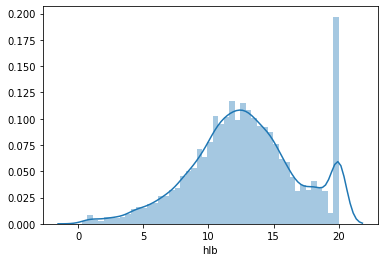

In [127]:
sns.distplot(dataset[HLB_COLUMN])

In [128]:
import matplotlib.pyplot as plt

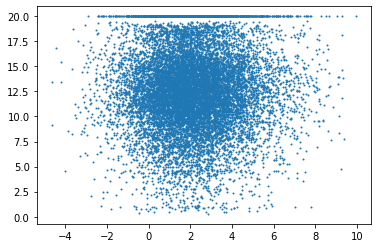

In [129]:
plt.scatter(dataset[VALUE_COLUMN], dataset[HLB_COLUMN], s = 1)

## Get feature family for each atom

In [134]:
import os
from rdkit import RDConfig
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures

In [135]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
print(featFactory.GetFeatureFamilies())

('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


In [131]:
from tqdm import tqdm
from rdkit.Chem import Descriptors
mols = dataset[SMILES_COLUMN].values
atoms_props = []

for smiles in tqdm(mols):
    m = Chem.MolFromSmiles(smiles)
    feats = featFactory.GetFeaturesForMol(m)
    atoms_props.append({})
    for feat in feats:
        atomsIds = feat.GetAtomIds()
        for atomId in atomsIds:
            if atomId not in atoms_props[-1].keys():
                atoms_props[-1][atomId] = []
            atoms_props[-1][atomId].append(feat.GetFamily())

100%|██████████| 13777/13777 [01:09<00:00, 197.08it/s]


In [133]:
atoms_props[:10]

[{5: ['Donor'], 2: ['Acceptor'], 4: ['Acceptor']},
 {5: ['Acceptor', 'Aromatic'],
  9: ['Acceptor'],
  2: ['Aromatic', 'Hydrophobe'],
  3: ['Aromatic'],
  6: ['Aromatic'],
  7: ['Aromatic'],
  8: ['Aromatic'],
  1: ['Hydrophobe']},
 {0: ['Donor'],
  2: ['Donor', 'Aromatic'],
  4: ['Donor', 'Aromatic'],
  8: ['Acceptor'],
  1: ['Aromatic'],
  3: ['Aromatic'],
  5: ['Aromatic'],
  9: ['Aromatic', 'Hydrophobe', 'LumpedHydrophobe'],
  10: ['Aromatic', 'LumpedHydrophobe'],
  11: ['Aromatic', 'LumpedHydrophobe'],
  12: ['Aromatic', 'LumpedHydrophobe'],
  13: ['Aromatic', 'LumpedHydrophobe'],
  14: ['Aromatic', 'LumpedHydrophobe']},
 {2: ['Donor', 'Acceptor', 'NegIonizable', 'ZnBinder'],
  9: ['Donor', 'Acceptor', 'NegIonizable', 'ZnBinder'],
  0: ['Acceptor', 'NegIonizable', 'ZnBinder'],
  8: ['Acceptor', 'NegIonizable', 'ZnBinder'],
  1: ['NegIonizable', 'ZnBinder'],
  7: ['NegIonizable', 'ZnBinder'],
  3: ['ZnBinder', 'Hydrophobe'],
  6: ['ZnBinder', 'Hydrophobe'],
  4: ['Hydrophobe'],
  5